<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 5. TDD in High and Low Gears</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Jan 12. 2021<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/05-tdd-in-high-and-low-gears/05-tdd-in-high-and-low-gears.ipynb">Download Jupyter Notebook</a>
</center>

# 05. TDD in High and Low Gears

## Introduction

### TDD Terms

#### Test Pyramid
- The "Test Pyramid" is a metaphor that tells us to group software tests into buckets of different granularity. It also gives an idea of how many tests we should have in each of these groups. Although the concept of the Test Pyramid has been around for a while, teams still struggle to put it into practice properly. 

*See also*:

- [The Practical Test Pyramid by Ham Vocke](https://martinfowler.com/articles/practical-test-pyramid.html)
- [Why the test pyramid is a bullsh*t — guide to testing towards modern frontend and backend apps](https://medium.com/@mateuszroth/why-the-test-pyramid-is-a-bullshit-guide-to-testing-towards-modern-frontend-and-backend-apps-4246e89b87bd)

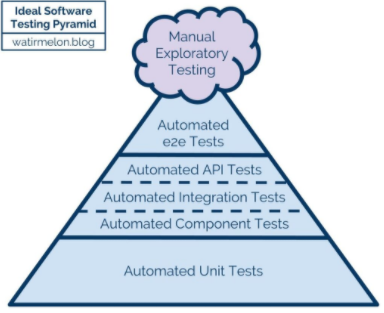 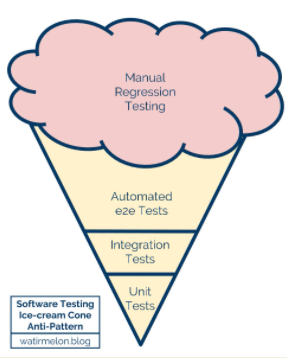

#### Test Double

Stunt Double(스턴트 대역) 에서 유래된 말입니다. 테스트를 대신해주는 "대역"을 뜻합니다.

Test double is a generic term for any case where you replace a production object for testing purposes. There are various kinds of double that Gerard lists, such as:

- **Dummy** objects are passed around but never actually used. Usually they are just used to fill parameter lists.
- **Fake** objects actually have working implementations, but usually take some shortcut which makes them not suitable for production (an InMemoryTestDatabase is a good example).
- **Stubs** provide canned answers to calls made during the test, usually not responding at all to anything outside what's programmed in for the test.
- **Spies** are stubs that also record some information based on how they were called. One form of this might be an email service that records how many messages it was sent.
- **Mocks** are pre-programmed with expectations which form a specification of the calls they are expected to receive. They can throw an exception if they receive a call they don't expect and are checked during verification to ensure they got all the calls they were expecting.

*See also*:

- [TestDouble by Martin Fowler](https://martinfowler.com/bliki/TestDouble.html)

### Difference between Various Kinds of Testing

**Unit testing** means testing individual modules of an application in isolation (without any interaction with dependencies) to confirm that the code is doing things right.

**Integration testing** means checking if different modules are working fine when combined together as a group.

**Functional testing** means testing a slice of functionality in the system (may interact with dependencies) to confirm that the code is doing the right things.

#### Integration Tests vs Functional Tests

Functional tests are related to integration tests, however, they signify to the tests that check the entire application’s functionality with all the code running together, nearly *a super integration test*.

*See also*:

  - [Unit Testing Vs Integration Testing Vs Functional Testing](https://www.softwaretestinghelp.com/the-difference-between-unit-integration-and-functional-testing/)

### Sanity Checks for the Project

Initial project adopted from chapter 4.

In [1]:
!tree app -I "__pycache__" --sort=version

app
├── __init__.py
├── __main__.py
├── adapters
│   ├── __init__.py
│   ├── orm.py
│   └── repository.py
├── apps
│   ├── __init__.py
│   ├── fastapi.py
│   └── flask.py
├── config.py
├── domain
│   ├── __init__.py
│   └── models.py
├── requirements.txt
├── routes
│   ├── __init__.py
│   └── flask.py
├── services
│   ├── __init__.py
│   └── batch.py
└── utils.py

5 directories, 17 files


**[팁]**
왜 `__init__.py` 파일이 필요할까요? 
- https://stackoverflow.com/questions/62831486/requirement-for-init-py-just-to-satisfy-pylint-and-mypy

> `__init__.py` used to be required to make directory a package
Namespace packages are packages without the `__init__.py.`
> 
> For an example of a simple package, if you have a directory:
>
> ```root
> +--package
>   +--file1.py
>   +--file2.py
>   ...
>
> ```
>
> While you could run these files independently in the package directory, e.g. with python2 file1.py, under Python 2 you wouldn't be able to import the files as modules in the root directory, e.g.
> 
> ```python
> import package.file1
>
>
> ```
>
> would fail, and in order for it to work, you at least need this:
>
> ```
> package
>  +--__init__.py
>  +--file1.py
>  +--file2.py
>  ...
>```

In [2]:
!mypy -p app --strict

Success: no issues found in 16 source files


In [3]:
!pytest tests

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/05-tdd-in-high-and-low-gears
plugins: flask-1.1.0, anyio-2.0.2
collected 25 items                                                             

tests/e2e/test_api.py .                                                  [  4%]
tests/integration/test_orm.py ......                                     [ 28%]
tests/integration/test_repository.py ..                                  [ 36%]
tests/unit/test_allocate.py ....                                         [ 52%]
tests/unit/test_batch.py .........                                       [ 88%]
tests/unit/test_services.py ...                                          [100%]

============================== 25 passed in 0.77s ==============================


In [4]:
!pylint app


--------------------------------------------------------------------
Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)



## How is our Test Pyramid Looking?

In [5]:
!grep -c test_ -R tests | grep -vE '__init__|conftest|__pycache__|.ipynb'

tests/unit/test_batch.py:9
tests/unit/test_allocate.py:4
tests/unit/test_services.py:3
tests/integration/test_orm.py:6
tests/integration/test_repository.py:2
tests/e2e/test_api.py:1


In [6]:
from subprocess import Popen, PIPE, STDOUT
from collections import defaultdict
proc = Popen("grep -c test_ -R tests | grep -vE '__init__|conftest|__pycache__|.ipynb'", shell=True, stdout=PIPE)
output = proc.stdout.read().decode().strip()
stats = defaultdict(lambda: 0)
for k, v in (it.split(':') for it in output.split('\n')):
    stats[k.split('/')[1]] += int(v)
dict(stats)

{'unit': 16, 'integration': 8, 'e2e': 1}

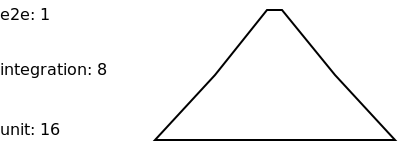

In [7]:
from app.utils import show_test_pyramid
show_test_pyramid(stats)

## Should Domain Layer Tests Move to the Service Layer?

Problems can happen from *too many* tests against their domain model.
- Sometime they *DO NOT reflect properties of a system*, but only low-level implementation of a system. 
- If we want to change *the design of our code*, any tests relying directly on the code will also fail.

따라서, 단위 테스트를 가급적 서비스 계층 영역으로 한정지어 깨지기 쉬운 도메인 레이어의 세부 구현에서 테스트를 보호하는 것이 좋습니다.

## On Deciding What Kind of Tests to Write

모든 유닛 테스트를 서비스 계층에 대해 재작성 해야 할까요? 도메인 모델에 직접 테스트 하는건 잘못된 것일까요? 이런 질문에 답하기 위해 테스트 종류에 따른 트레이드 오프(테스트 스펙트럼)를 이해해야 합니다.

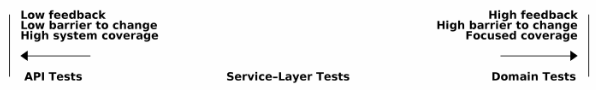

테스트의 목적은 변경에 대한 피드백을 얻기 위함입니다. 테스트가 실제 구현에 가까울 수록 더 좁은 범위(커버리지)에서 강한 피드백을 받게 됩니다. 높은 단계의 추상화에 가까울 수록 테스트는 대규모 변경에 대한 넓은 범위의 피드백을 얻게 됩니다.

서비스 계층에 대한 테스트(API 테스트)는 특정 구현에 종속되지 않은 시스템의 특성을 체크하고 대규모 변경에 대한 자신감을 얻기 위해 사용합니다.     

특히 도메인 테스트에 대한 피드백은 시스템 세부사항에 대한 즉각적이고 강력한 피드백을 주어 시스템을 이해하는데 큰 도움을 줍니다. 즉, 도메인 테스트는 도메인 언어로 쓰여진 일종의 "살아있는 문서" 역할을 합니다.

신규 프로젝트를 수행하여 아직 도메인에 대해서 잘 알지 못할 경우 "도메인 모델에 대한 테스트"는 시스템의 이해를 돕고 실제 코드를 어덯게 작성할지 감을 찾는데 매우 효과적입니다. 

한편 도메인에 대한 이해가 충분히 되고, 설계 개선이 필요하다고 판단되면 세부 구현에 종속된 이런 테스트들을 API 레벨로 교체할 필요가 있습니다.

## High Gear(저속 기어) and Low Gear(고속 기어)

기존 기능을 확장하거나 버그 수정을 할 경우, 도메인 모델의 수정이 거의 필요하지 않다면 효과적으로 달리기 위해 고속 기어(서비스 레벨 테스트)를 놓고 달립니다.

하지만 처음 프로젝트를 시작해서 도메인을 잘 모르거나, 중요하고 어려운 작업을 신중하게 수행해야 할 경우 저속 기어(도메인 레벨 테스트)로 전환하여 어려움을 극복할 수 있습니다.

## Fully Decoupling the Service-Layer Tests from the Domain

이전 챕터에서 서비스 계층 테스트에 도메인 객체를 직접 사용하고 있었는데 좋지 않은 패턴이므로 분리해보도록 합시다.

In [8]:
from app.services import batch
?batch.allocate

Signature:
batch.allocate(
    line: app.domain.models.OrderLine,
    repo: app.adapters.repository.AbstractRepository,
    session: app.adapters.orm.AbstractSession,
) -> str
Docstring: Find an earliest batch and allocate an :class:`.OrderLine` to it.
File:      ~/notebooks/2021-msa-study/05-tdd-in-high-and-low-gears/app/services/batch.py
Type:      function


`services.batch.allocate` 서비스 함수 파라메터가 도메인 객체를 의존하고 있습니다. 파라메터 타입을 원시 타입으로 바꿔 봅시다.

In [9]:
from app.adapters.repository import AbstractRepository
from app.adapters.orm import AbstractSession
from app.domain import models
from app.services.batch import is_valid_sku, InvalidSku

In [10]:
# services/batch.py 
def allocate(orderid: str, sku: str, qty: int, repo: AbstractRepository,
             session: AbstractSession) -> str:
    """Find an earliest batch and allocate an :class:`.OrderLine` to it."""
    line = models.OrderLine(orderid, sku, qty)
    batches = repo.list()
    if not is_valid_sku(line.sku, batches):
        raise InvalidSku(f'Invalid sku {line.sku}')
    batchref = models.allocate(line, batches)
    session.commit()
    return batchref

개선한 서비스 함수를 성공시키도록 테스트를 재작성해봅시다.

In [11]:
from unittest.mock import MagicMock
services = MagicMock()
services.batch.allocate = allocate

In [12]:
from tests import mytest
from tests.unit import test_services
from tests.unit.test_services import FakeSession, FakeRepository
from app.domain import models

In [13]:
# tests/unit/test_services.py
@mytest.test
def test_returns_allocation():
    batch = models.Batch("batch1", "COMPLICATED-LAMP", 100, eta=None)
    repo = FakeRepository([batch])

    result = services.batch.allocate("o1", "COMPLICATED-LAMP", 10, repo, test_services.FakeSession())
    assert "batch1" == result 

✅ test_returns_allocation


하지만 찝찝하게도 테스트가 아직 도메인 객체 `Batch`를 참고합니다. 도메인 객체 구현이 엄청나게 바뀐다면 이를 참조하는 테스트들 다수가 실패할 것입니다. 

### Mitigation: Keep All Domain Dependencies in Fixture Functions

이를 개선하기 위해 `FakeRepository` 에 `Batch` 모델 생성을 위임해봅시다. 이제 테스트가 더이상 도메인 객체에 의존하지 않게 되어 좀더 강건한 테스트가 되었습니다.

In [14]:
class FakeRepository(test_services.FakeRepository):
    
    @staticmethod
    def for_batch(ref, sku, qty, eta=None):
        return FakeRepository([
            models.Batch(ref, sku, qty, eta),
        ])
    
    
@mytest.test
def test_returns_allocation():
    repo = FakeRepository.for_batch("batch1", "COMPLICATED-LAMP", 100, eta=None)
    result = allocate("o1", "COMPLICATED-LAMP", 10, repo, test_services.FakeSession())
    assert "batch1" == result 

✅ test_returns_allocation


### Adding a Missing Service

생각해보면, `Batch` 추가 작업 자체를 서비스로 함수로 정의하면 서비스 계층 테스트를 실제 서비스를 사용하는 방식으로 재작성할 수 있습니다. 이러면 도메인에 대한 의존이 완전히 제거됩니다.

일반적으로 서비스 계층 테스트가 도메인 객체를 참조한다면 이는 서비스 계층이 불완전하다는 조짐일 수 있습니다.

In [15]:
# services/batch.py
from typing import Optional
from datetime import date

def add_batch(
        ref: str, sku: str, qty: int, eta: Optional[date],
        repo: AbstractRepository, session,
):
    repo.add(models.Batch(ref, sku, qty, eta))
    session.commit()
    
    
services.batch.add = add_batch

In [16]:
@mytest.test
def test_add_batch():
    repo, session = FakeRepository([]), FakeSession()
    assert not session.committed
    services.batch.add("b1", "CRUNCHY-ARMCHAIR", 100, None, repo, session)
    assert repo.get("b1") is not None
    assert session.committed

✅ test_add_batch


이제 모든 서비스 계층 테스트를 서비스로만 나타낼 수 있습니다.

In [17]:
import pytest

services.batch.InvalidSku = batch.InvalidSku

@mytest.test
def test_allocate_returns_allocation():
    repo, session = FakeRepository([]), FakeSession()
    services.batch.add("batch1", "COMPLICATED-LAMP", 100, None, repo, session)
    result = services.batch.allocate("o1", "COMPLICATED-LAMP", 10, repo, session)
    assert "batch1" == result 


@mytest.test
def test_allocate_errors_for_invalid_sku():
    repo, session = FakeRepository([]), FakeSession()
    services.batch.add("b1", "AREALSKU", 100, None, repo, session)

    with pytest.raises(services.batch.InvalidSku, match="Invalid sku NONEXISTENTSKU"):
        services.batch.allocate("o1", "NONEXISTENTSKU", 10, repo, FakeSession())

✅ test_allocate_returns_allocation
✅ test_allocate_errors_for_invalid_sku


## Carrying the Improvment Through to the E2E Tests

같은 방식으로 지저분한 `add_stock` 픽스쳐 대신 `Batch` 를 추가하는 엔드포인트를 만들어 E2E 테스트가 SQL과 DB에 의존하지 않도록 리팩토링할 수 있습니다.

In [18]:
from tests.e2e import restart_flask_server, stop_flask_server, CustomFlask

In [19]:
test_app = CustomFlask('test_app')
restart_flask_server(test_app)

starting server... started.


RESTful 한 엔드포인트로 바꾸기 위해 책에서의 경로 `/add_batch` 대신 `/batches` 로 경로를 바꿨습니다.

In [20]:
from app.adapters.orm import start_mappers, init_engine, sessionmaker, get_scoped_session
from app import config

metadata = start_mappers()
engine = init_engine(metadata, config.get_db_url())
get_session = sessionmaker(engine)
get_repo = lambda: SqlAlchemyRepository(get_session())

In [21]:
from app.adapters.repository import SqlAlchemyRepository
from datetime import datetime
from flask import request, jsonify

@test_app.route("/batches", methods=['POST'])
def add_batch():
    with get_repo() as repo:
        eta = request.json['eta']
        if eta is not None:
            eta = datetime.fromisoformat(eta).date()
        services.batch.add(
            request.json['ref'], request.json['sku'], request.json['qty'], eta,
            repo, repo.session
        )
    return 'OK', 201

@test_app.route('/batches/allocate', methods=['POST'])
def allocate_batch():
    with get_repo() as repo:
        batches = repo.list()
        line = models.OrderLine(
            request.json['orderid'],
            request.json['sku'],
            request.json['qty'],
        )
        batchref = models.allocate(line, batches)

    return jsonify({'batchref': batchref}), 201

기존 API 테스트는 다음과 같이 `add_stock` 을 통해 레포지터리 같은 저장소 구현에 의존해야 했습니다.

```python
def test_api_returns_allocation(add_stock: AddStockFunc) -> None:
    ...
```

리팩토링된 테스트는 서비스 API 엔드포인트 호출 외에는 의존이 전부 제거되어 진정한 의미의 E2E 테스트가 되었습니다. 

In [22]:
import requests

from tests.e2e.test_api import random_batchref, random_sku, random_orderid
from app import config

def post_to_add_batch(ref, sku, qty, eta):
    url = config.get_api_url()
    r = requests.post(
        f'{url}/batches',
        json={'ref': ref, 'sku': sku, 'qty': qty, 'eta': eta}
    )
    assert r.status_code == 201
    
with get_repo() as repo:
    repo.clear()

@mytest.test
def test_happy_path_returns_201_and_allocated_batch():
    sku, othersku = random_sku(), random_sku('other')
    earlybatch = random_batchref(1)
    laterbatch = random_batchref(2)
    otherbatch = random_batchref(3)
    post_to_add_batch(laterbatch, sku, 100, '2011-01-02')
    post_to_add_batch(earlybatch, sku, 100, '2011-01-01')
    post_to_add_batch(otherbatch, othersku, 100, None)
    data = {'orderid': random_orderid(), 'sku': sku, 'qty': 3}
    url = config.get_api_url()
    r = requests.post(f'{url}/batches/allocate', json=data)
    assert r.status_code == 201
    assert r.json()['batchref'] == earlybatch

127.0.0.1 - - [16/Jan/2021 12:28:34] "POST /batches HTTP/1.1" 201 -
127.0.0.1 - - [16/Jan/2021 12:28:34] "POST /batches HTTP/1.1" 201 -
127.0.0.1 - - [16/Jan/2021 12:28:34] "POST /batches HTTP/1.1" 201 -
127.0.0.1 - - [16/Jan/2021 12:28:34] "POST /batches/allocate HTTP/1.1" 201 -


✅ test_happy_path_returns_201_and_allocated_batch


## Wrap-Up

테스트의 대부분을 서비스 계층에 대한 테스트로 개선하면 코드 변경에 강건한 건강한 테스트 피라미드를 유지할 수 있습니다!

- 서비스 계층 함수 파라메터를 도메인 객체가 아닌 기본 타입으로 나타내세요!
- 레포지터리나 DB 상태를 임의로 수정하지 않고 서비스 계층에만 한정된 테스트를 만드는것이 이상적입니다. 이런 노력의 댓가를 E2E 테스트에서 얻게 될 것입니다.

### RECAP: RULES OF THUMB FOR DIFFERENT TYPES OF TEST

- Aim for one end-to-end test per feature
- Write the bulk of your tests against the service layer
- Maintain a small core of tests written against your domain model
- Error handling counts as a feature

In [23]:
# clean up resources...
stop_flask_server()

shutting down server...
